# Demystifying Markov Chain Monte Carlo

#### Brett Morris

### In this tutorial 

We will write our own Markov Chain Monte Carlo algorithm with a Metropolis-Hastings sampler. 

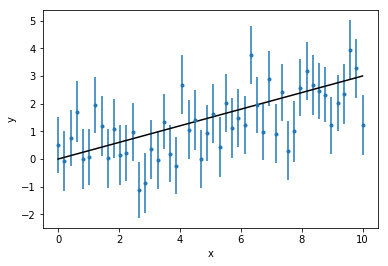

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

# Set the properties of the line that we'll be fitting: 
true_slope = 0.3
true_intercept = 0.0

x = np.linspace(0, 10, 50)
y = np.random.randn(len(x)) + true_slope * x + true_intercept
yerr = np.random.rand(len(x))/10 + 1

plt.errorbar(x, y, yerr, fmt='.')
plt.plot(x, true_slope * x + true_intercept, color='k')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We define a simple linear model to describe the data, which has parameters $\theta = \{m, b\}$.

In [ ]:
def linear_model(theta, x): 
    """
    Simple linear model. 
    """
    m, b = theta
    return m * x + b


def chi2(theta, x, y, yerr, model): 
    """
    Compute the \chi^2 by comparing `model` evaluated at `theta`
    to `y` at each value of `x`. 
    """
    return np.sum((model(theta, x) - y)**2 / yerr**2)

Let the proposal step simply draw from a Gaussian distribution:  

In [ ]:
def proposal(theta, scale=1):
    """
    Generate proposal step, by adding a draw from a 
    Gaussian distribution to the initial step position
    """
    return theta + scale * np.random.randn(len(theta))

We will decide whether or not to accept new proposal steps using the Metropolis-Hastings algorithm, as defined by [Ford (2005)](https://arxiv.org/abs/astro-ph/0305441):

In [214]:
def metropolis_hastings(init_theta, x, y, yerr, acceptance, scale=0.05):
    """
    Metropolis-Hastings algorithm, a la Ford (2005). 
    
    1) Generate a proposal step
    2) Compare the chi^2 of the proposal step to the current step
    3) Draw a random number `u` on [0, 1]
    4) Compute alpha = min([exp(-0.5 * (chi2(new) - chi2(old)), 1])
    5) If u <= alpha, accept step, otherwise keep step
    6) Return to step (1)
    """
    # Generate a proposal step: 
    proposed_theta = proposal(init_theta, scale=scale)

    # Compare chi^2 of proposed step to current step:
    chi2_init_step = chi2(init_theta, x, y, yerr, linear_model)
    chi2_proposed_step = chi2(proposed_theta, x, y, yerr, linear_model)
    relative_likelihood = np.exp(-0.5 * (chi2_proposed_step - chi2_init_step))
    
    alpha = np.min([relative_likelihood, 1])

    # If U(0, 1) <= alpha, accept the step: 
    if np.random.rand() <= alpha: 
        return proposed_theta, acceptance + 1
    else: 
        return init_theta, acceptance
    

def sampler(x, y, yerr, init_theta, n_steps, scale=0.05):
    """
    Markov Chain Monte Carlo sampler. 
    """
    current_theta = np.copy(init_theta)
    # Allocate memory for samples: 
    samples = np.zeros((n_steps, len(init_theta)))
    samples[0, :] = init_theta
    acceptance = 0
    
    for i in range(1, n_steps):
        # Run the M-H algorithm to determine next step:
        current_theta, acceptance = metropolis_hastings(current_theta, 
                                                        x, y, yerr, acceptance, 
                                                        scale=scale)
        # Record the result: 
        samples[i, :] = current_theta
        
    # Compute the final acceptance rate
    acceptance_rate = acceptance / n_steps
    
    return samples, acceptance_rate

Make an initial guess (which is wrong!) and let the MCMC algorithm find the correct solution: 

In [221]:
init_parameters = [1, 0.5]  # slope, intercept
n_steps = 50000

# This tweakable parameter determines how
# far new steps should be taken away from 
# previous steps. Increase `scale` to 
# decrease your acceptance rate: 
scale = 0.06

samples, acceptance_rate = sampler(x, y, yerr, init_parameters, 
                                   n_steps, scale=scale)

What is the acceptance rate? Ideally this should be near 45%:

In [222]:
print(acceptance_rate)

0.43406


Let's plot a few random draws from the posterior probability distribution functions for each parameter: 

Text(0, 0.5, 'y')

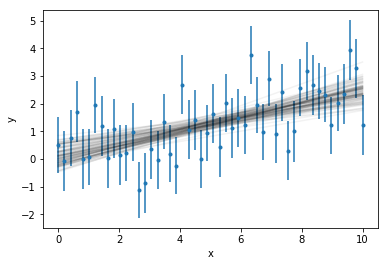

In [223]:
for i in range(100): 
    random_step = np.random.randint(0, samples.shape[0])
    random_theta = samples[random_step, :]
    plt.plot(x, linear_model_1(random_theta, x), alpha=0.05, color='k')
plt.errorbar(x, y, yerr, fmt='.')
plt.xlabel('x')
plt.ylabel('y')

You can see that the uncertainty in the measurements is being reflected by uncertainty in the slope and intercept parameters. 

We normally see the posterior probability distribution functions displayed in a "corner" plot like the one below: 

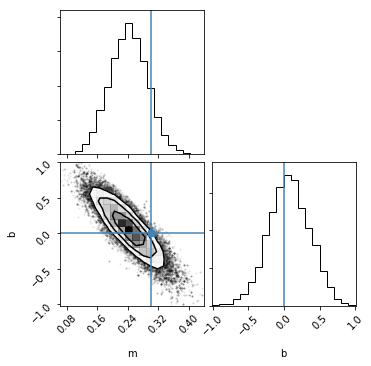

In [224]:
from corner import corner

burned_in_samples = samples[1000:]

corner(burned_in_samples, labels=['m', 'b'], truths=[true_slope, true_intercept]);

Note that the posterior distributions are consistent within the uncertainties for each parameter! We are accurately measuring each parameter and their uncertainties. 

### Parameter Degeneracies

But these parameters $m$ and $b$ are correlated with one another – note that small values of $m$ correspond to large values of $b$ while small values of $b$ correspond to large values of $m$. We can get rid of this degeneracy by reparameterizing our model to fit for the parameters $\theta$ and $b$, see [Hogg et al. (2010)](https://arxiv.org/abs/1008.4686). 